In [10]:
import multiprocessing
import threading
import tensorflow as tf
import numpy as np
import gym
import os
import shutil
import matplotlib.pyplot as plt

In [11]:
import multiprocessing
import threading
import tensorflow as tf
import numpy as np
import gym
import os
import shutil
import matplotlib.pyplot as plt

GAME = 'Pendulum-v0'
OUTPUT_GRAPH = True
LOG_DIR = '/home/adrian/Schreibtisch/Uni/Data-Innovation-Lab/tensorflowlogs'
N_WORKERS = multiprocessing.cpu_count()
MAX_EP_STEP = 200
MAX_GLOBAL_EP = 1500
GLOBAL_NET_SCOPE = 'Global_Net'
UPDATE_GLOBAL_ITER = 5
GAMMA = 0.9
ENTROPY_BETA = 0.01
LR_A = 0.0001    # learning rate for actor
LR_C = 0.001    # learning rate for critic
GLOBAL_RUNNING_R = []
GLOBAL_EP = 0

env = gym.make(GAME)

N_S = env.observation_space.shape[0]
N_A = env.action_space.shape[0]
A_BOUND = [env.action_space.low, env.action_space.high]


class ACNet(object):
    def __init__(self, scope, globalAC=None):

        if scope == GLOBAL_NET_SCOPE:   # get global network
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_params, self.c_params = self._build_net(scope)[-2:]
        else:   # local net, calculate losses
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_his = tf.placeholder(tf.float32, [None, N_A], 'A')
                self.v_target = tf.placeholder(tf.float32, [None, 1], 'Vtarget')

                mu, sigma, self.v, self.a_params, self.c_params = self._build_net(scope)

                td = tf.subtract(self.v_target, self.v, name='TD_error')
                with tf.name_scope('c_loss'):
                    self.c_loss = tf.reduce_mean(tf.square(td))

                with tf.name_scope('wrap_a_out'):
                    mu, sigma = mu * A_BOUND[1], sigma + 1e-4

                normal_dist = tf.distributions.Normal(mu, sigma)

                with tf.name_scope('a_loss'):
                    log_prob = normal_dist.log_prob(self.a_his)
                    exp_v = log_prob * td
                    entropy = normal_dist.entropy()  # encourage exploration
                    self.exp_v = ENTROPY_BETA * entropy + exp_v
                    self.a_loss = tf.reduce_mean(-self.exp_v)

                with tf.name_scope('choose_a'):  # use local params to choose action
                    self.A = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=0), A_BOUND[0], A_BOUND[1])
                with tf.name_scope('local_grad'):
                    self.a_grads = tf.gradients(self.a_loss, self.a_params)
                    self.c_grads = tf.gradients(self.c_loss, self.c_params)

            with tf.name_scope('sync'):
                with tf.name_scope('pull'):
                    self.pull_a_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.a_params, globalAC.a_params)]
                    self.pull_c_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.c_params, globalAC.c_params)]
                with tf.name_scope('push'):
                    self.update_a_op = OPT_A.apply_gradients(zip(self.a_grads, globalAC.a_params))
                    self.update_c_op = OPT_C.apply_gradients(zip(self.c_grads, globalAC.c_params))

    def _build_net(self, scope):
        w_init = tf.random_normal_initializer(0., .1)
        with tf.variable_scope('critic'):   # only critic controls the rnn update
            cell_size = 64
            s = tf.expand_dims(self.s, axis=1,
                               name='timely_input')  # [time_step, feature] => [time_step, batch, feature]
            rnn_cell = tf.contrib.rnn.BasicRNNCell(cell_size)
            self.init_state = rnn_cell.zero_state(batch_size=1, dtype=tf.float32)
            outputs, self.final_state = tf.nn.dynamic_rnn(
                cell=rnn_cell, inputs=s, initial_state=self.init_state, time_major=True)
            cell_out = tf.reshape(outputs, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation
            l_c = tf.layers.dense(cell_out, 50, tf.nn.relu6, kernel_initializer=w_init, name='lc')
            v = tf.layers.dense(l_c, 1, kernel_initializer=w_init, name='v')  # state value

        with tf.variable_scope('actor'):  # state representation is based on critic
            l_a = tf.layers.dense(cell_out, 80, tf.nn.relu6, kernel_initializer=w_init, name='la')
            mu = tf.layers.dense(l_a, N_A, tf.nn.tanh, kernel_initializer=w_init, name='mu')
            sigma = tf.layers.dense(l_a, N_A, tf.nn.softplus, kernel_initializer=w_init, name='sigma')
        a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
        return mu, sigma, v, a_params, c_params

    def update_global(self, feed_dict):  # run by a local
        SESS.run([self.update_a_op, self.update_c_op], feed_dict)  # local grads applies to global net

    def pull_global(self):  # run by a local
        SESS.run([self.pull_a_params_op, self.pull_c_params_op])

    def choose_action(self, s, cell_state):  # run by a local
        s = s[np.newaxis, :]
        a, cell_state = SESS.run([self.A, self.final_state], {self.s: s, self.init_state: cell_state})
        return a[0], cell_state


class Worker(object):
    def __init__(self, name, globalAC):
        self.env = gym.make(GAME).unwrapped
        self.name = name
        self.AC = ACNet(name, globalAC)

    def work(self):
        global GLOBAL_RUNNING_R, GLOBAL_EP
        total_step = 1
        buffer_s, buffer_a, buffer_r = [], [], []
        while not COORD.should_stop() and GLOBAL_EP < MAX_GLOBAL_EP:
            s = self.env.reset()
            ep_r = 0
            rnn_state = SESS.run(self.AC.init_state)    # zero rnn state at beginning
            keep_state = rnn_state.copy()       # keep rnn state for updating global net
            for ep_t in range(MAX_EP_STEP):
                if self.name == 'W_0':
                    self.env.render()

                a, rnn_state_ = self.AC.choose_action(s, rnn_state)  # get the action and next rnn state
                s_, r, done, info = self.env.step(a)
                done = True if ep_t == MAX_EP_STEP - 1 else False

                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append((r+8)/8)    # normalize

                if total_step % UPDATE_GLOBAL_ITER == 0 or done:   # update global and assign to local net
                    if done:
                        v_s_ = 0   # terminal
                    else:
                        v_s_ = SESS.run(self.AC.v, {self.AC.s: s_[np.newaxis, :], self.AC.init_state: rnn_state_})[0, 0]
                    buffer_v_target = []
                    for r in buffer_r[::-1]:    # reverse buffer r
                        v_s_ = r + GAMMA * v_s_
                        buffer_v_target.append(v_s_)
                    buffer_v_target.reverse()

                    buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.vstack(buffer_a), np.vstack(buffer_v_target)

                    feed_dict = {
                        self.AC.s: buffer_s,
                        self.AC.a_his: buffer_a,
                        self.AC.v_target: buffer_v_target,
                        self.AC.init_state: keep_state,
                    }

                    self.AC.update_global(feed_dict)
                    buffer_s, buffer_a, buffer_r = [], [], []
                    self.AC.pull_global()
                    keep_state = rnn_state_.copy()   # replace the keep_state as the new initial rnn state_

                s = s_
                rnn_state = rnn_state_  # renew rnn state
                total_step += 1

                if done:
                    if len(GLOBAL_RUNNING_R) == 0:  # record running episode reward
                        GLOBAL_RUNNING_R.append(ep_r)
                    else:
                        GLOBAL_RUNNING_R.append(0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * ep_r)
                    print(
                        self.name,
                        "Ep:", GLOBAL_EP,
                        "| Ep_r: %i" % GLOBAL_RUNNING_R[-1],
                          )
                    GLOBAL_EP += 1
                    break

W_1 Ep: 0 | Ep_r: -1314
W_3 Ep: 1 | Ep_r: -1330
W_2 Ep: 2 | Ep_r: -1359
W_3 Ep: 3 | Ep_r: -1386
W_1 Ep: 4 | Ep_r: -1388
W_2 Ep: 5 | Ep_r: -1420
W_1 Ep: 6 | Ep_r: -1416
W_2 Ep: 7 | Ep_r: -1399
W_3 Ep: 8 | Ep_r: -1397
W_1 Ep: 9 | Ep_r: -1400
W_2 W_3 Ep: 10 Ep:| Ep_r: -1427 
10 | Ep_r: -1419
W_0 Ep: 12 | Ep_r: -1433
W_2 W_1 Ep: Ep:13 | Ep_r: -1439
 13 W_3 Ep:| Ep_r: -1432
 14 | Ep_r: -1433
W_2 Ep: 16 | Ep_r: -1382
W_1 Ep: 17 | Ep_r: -1370
W_3 Ep: 18 | Ep_r: -1390
W_2 Ep: 19 | Ep_r: -1369
W_3 Ep: 20W_1 | Ep_r: -1336 
Ep: 21 | Ep_r: -1331
W_0 Ep: 22 | Ep_r: -1311
W_2 Ep: 23 | Ep_r: -1292
W_3W_1 Ep: 24 | Ep_r: -1277
 Ep: 24 | Ep_r: -1255
W_2 Ep: 26 | Ep_r: -1299
W_3 Ep: 27 | Ep_r: -1316
W_1 Ep: 28 | Ep_r: -1282
W_2 Ep: 29 | Ep_r: -1261
W_1 Ep: 30 | Ep_r: -1229
W_3 Ep: 31 | Ep_r: -1214
W_2 Ep: 32 | Ep_r: -1197
W_1 Ep: 33 | Ep_r: -1172
W_3 Ep: 34 | Ep_r: -1147
W_0 Ep: 35 | Ep_r: -1140
W_2 Ep: 36 | Ep_r: -1146
W_1 Ep: 37 | Ep_r: -1168
W_3 Ep: 38 | Ep_r: -1200
W_2 Ep: 39 | Ep_r: -1257
W_1 Ep: 40

W_1 Ep: 329 | Ep_r: -617
W_3 Ep: 330 | Ep_r: -608
W_2 Ep: 331 | Ep_r: -592
W_1 Ep: 332 | Ep_r: -609
W_3 Ep: 333 | Ep_r: -601
W_2 Ep: 334 | Ep_r: -594
W_0 Ep: 335 | Ep_r: -593
W_1 Ep: 336 | Ep_r: -587
W_3 Ep: 337 | Ep_r: -578
W_2 Ep: 338 | Ep_r: -587
W_1 Ep: 339 | Ep_r: -555
W_3 Ep: 340 | Ep_r: -569
W_2 Ep: 341 | Ep_r: -605
W_1 Ep: 342 | Ep_r: -585
W_3 Ep: 343 | Ep_r: -579
W_2 Ep: 344 | Ep_r: -605
W_3 Ep: 345 | Ep_r: -612
W_1 Ep: 346 | Ep_r: -619
W_0 Ep: 347 | Ep_r: -600
W_2 Ep: 348 | Ep_r: -606
W_3 Ep: 349 | Ep_r: -612
W_1 Ep: 350 | Ep_r: -604
W_2 Ep: 351 | Ep_r: -583
W_3 Ep: 352 | Ep_r: -608
W_1 Ep: 353 | Ep_r: -649
W_2 Ep: 354 | Ep_r: -683
W_3 Ep: 355 | Ep_r: -668
W_1 Ep: 356 | Ep_r: -696
W_2 Ep: 357 | Ep_r: -687
W_3 Ep: 358 | Ep_r: -687
W_1 Ep: 359 | Ep_r: -671
W_0 Ep: 360 | Ep_r: -671
W_2 Ep: 361 | Ep_r: -661
W_1 Ep: 362 | Ep_r: -674
W_3 Ep: 363 | Ep_r: -620
W_2 Ep: 364 | Ep_r: -585
W_1 Ep: 365 | Ep_r: -594
W_3 Ep: 366 | Ep_r: -604
W_2 Ep: 367 | Ep_r: -571
W_1 Ep: 368 | Ep_r: -544


W_2 Ep: 657 | Ep_r: -625
W_1 Ep: 658 | Ep_r: -643
W_3 Ep: 659 | Ep_r: -646
W_0 Ep: 660 | Ep_r: -623
W_2 Ep: 661 | Ep_r: -588
W_1 Ep: 662 | Ep_r: -529
W_3 Ep: 663 | Ep_r: -543
W_2 Ep: 664 | Ep_r: -530
W_1 Ep: 665 | Ep_r: -552
W_3 Ep: 666 | Ep_r: -566
W_2 Ep: 667 | Ep_r: -563
W_1 Ep: 668 | Ep_r: -593
W_3 Ep: 669 | Ep_r: -600
W_2 Ep: 670 | Ep_r: -626
W_3 Ep: 671 | Ep_r: -564
W_1 Ep: 672 | Ep_r: -562
W_0 Ep: 673 | Ep_r: -533
W_2 Ep: 674 | Ep_r: -550
W_3 Ep: 675 | Ep_r: -549
W_1 Ep: 676 | Ep_r: -507
W_2 Ep: 677 | Ep_r: -470
W_3 Ep: 678 | Ep_r: -463
W_1 Ep: 679 | Ep_r: -442
W_2 Ep: 680 | Ep_r: -411
W_3 Ep: 681 | Ep_r: -397
W_1 Ep: 682 | Ep_r: -422
W_2 Ep: 683 | Ep_r: -462
W_3 Ep: 684 | Ep_r: -482
W_1 Ep: 685 | Ep_r: -493
W_0 Ep: 686 | Ep_r: -519
W_2 Ep: 687 | Ep_r: -549
W_3 Ep: 688 | Ep_r: -534
W_1 Ep: 689 | Ep_r: -493
W_2 Ep: 690 | Ep_r: -487
W_3 Ep: 691 | Ep_r: -438
W_1 Ep: 692 | Ep_r: -421
W_2 Ep: 693 | Ep_r: -442
W_3 Ep: 694 | Ep_r: -398
W_1 Ep: 695 | Ep_r: -371
W_2 Ep: 696 | Ep_r: -348


W_3 Ep: 985 | Ep_r: -362
W_1 Ep: 986 | Ep_r: -408
W_2 Ep: 987 | Ep_r: -408
W_3 Ep: 988 | Ep_r: -402
W_1 Ep: 989 | Ep_r: -402
W_2 Ep: 990 | Ep_r: -388
W_3 Ep: 991 | Ep_r: -390
W_1 Ep: 992 | Ep_r: -364
W_2 Ep: 993 | Ep_r: -390
W_0 Ep: 994 | Ep_r: -391
W_3 Ep: 995 | Ep_r: -420
W_1 Ep: 996 | Ep_r: -474
W_2 Ep: 997 | Ep_r: -511
W_3 Ep: 998 | Ep_r: -530
W_1 Ep: 999 | Ep_r: -544
W_2 Ep: 1000 | Ep_r: -556
W_3 Ep: 1001 | Ep_r: -540
W_1 Ep: 1002 | Ep_r: -513
W_2 Ep: 1003 | Ep_r: -502
W_0 Ep: 1004 | Ep_r: -492
W_3 Ep: 1005 | Ep_r: -511
W_1 Ep: 1006 | Ep_r: -487
W_2 Ep: 1007 | Ep_r: -478
W_3 Ep: 1008 | Ep_r: -484
W_1 Ep: 1009 | Ep_r: -486
W_2 Ep: 1010 | Ep_r: -491
W_1 Ep: 1011 | Ep_r: -534
W_3 Ep: 1012 | Ep_r: -563
W_2 Ep: 1013 | Ep_r: -588
W_1 Ep: 1014 | Ep_r: -616
W_3 Ep: 1015 | Ep_r: -625
W_2 Ep: 1016 | Ep_r: -590
W_0 Ep: 1017 | Ep_r: -584
W_1 Ep: 1018 | Ep_r: -552
W_3 Ep: 1019 | Ep_r: -567
W_2 Ep: 1020 | Ep_r: -578
W_1 Ep: 1021 | Ep_r: -594
W_3 Ep: 1022 | Ep_r: -575
W_2 Ep: 1023 | Ep_r: -558
W

W_3 Ep: 1301 | Ep_r: -422
W_2 Ep: 1302 | Ep_r: -421
W_1 Ep: 1303 | Ep_r: -406
W_3 Ep: 1304 | Ep_r: -392
W_2 Ep: 1305 | Ep_r: -384
W_1 Ep: 1306 | Ep_r: -373
W_3 Ep: 1307 | Ep_r: -395
W_2 Ep: 1308 | Ep_r: -442
W_1 Ep: 1309 | Ep_r: -451
W_3 Ep: 1310 | Ep_r: -433
W_0 Ep: 1311 | Ep_r: -445
W_2 Ep: 1312 | Ep_r: -468
W_1 Ep: 1313 | Ep_r: -461
W_3 Ep: 1314 | Ep_r: -471
W_2 Ep: 1315 | Ep_r: -475
W_1 Ep: 1316 | Ep_r: -481
W_3 Ep: 1317 | Ep_r: -472
W_2 Ep: 1318 | Ep_r: -477
W_1 Ep: 1319 | Ep_r: -469
W_3 Ep: 1320 | Ep_r: -463
W_2 Ep: 1321 | Ep_r: -430
W_1 Ep: 1322 | Ep_r: -400
W_3 Ep: 1323 | Ep_r: -392
W_2 Ep: 1324 | Ep_r: -422W_0 Ep:
 1324 | Ep_r: -434
W_1 Ep: 1326 | Ep_r: -446
W_3 Ep: 1327 | Ep_r: -473
W_2 Ep: 1328 | Ep_r: -495
W_1 Ep: 1329 | Ep_r: -473
W_3 Ep: 1330 | Ep_r: -466
W_2 Ep: 1331 | Ep_r: -446
W_1 Ep: 1332 | Ep_r: -472
W_3 Ep: 1333 | Ep_r: -464
W_2 Ep: 1334 | Ep_r: -446
W_1 Ep: 1335 | Ep_r: -442
W_3 Ep: 1336 | Ep_r: -411
W_0 Ep: 1337 | Ep_r: -409
W_2 Ep: 1338 | Ep_r: -381
W_1 Ep: 1339

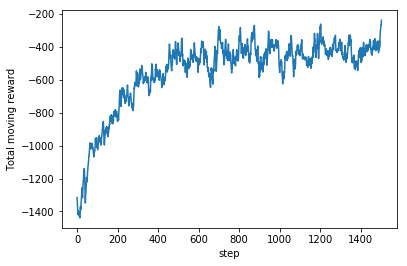

In [12]:
tf.reset_default_graph()
SESS = tf.Session()

with tf.device("/cpu:0"):
    OPT_A = tf.train.RMSPropOptimizer(LR_A, name='RMSPropA')
    OPT_C = tf.train.RMSPropOptimizer(LR_C, name='RMSPropC')
    GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)  # we only need its params
    workers = []
    # Create worker
    for i in range(N_WORKERS):
        i_name = 'W_%i' % i   # worker name
        workers.append(Worker(i_name, GLOBAL_AC))

COORD = tf.train.Coordinator()
SESS.run(tf.global_variables_initializer())

if OUTPUT_GRAPH:
    if os.path.exists(LOG_DIR):
        shutil.rmtree(LOG_DIR)
    tf.summary.FileWriter(LOG_DIR, SESS.graph)

worker_threads = []
for worker in workers:
    job = lambda: worker.work()
    t = threading.Thread(target=job)
    t.start()
    worker_threads.append(t)
COORD.join(worker_threads)

plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
plt.xlabel('step')
plt.ylabel('Total moving reward')
plt.show()

In [3]:
env = gym.make(GAME)

N_S = env.observation_space.shape[0]
N_A = env.action_space.shape[0]
A_BOUND = [env.action_space.low, env.action_space.high]

In [10]:
#sess.close()
tf.reset_default_graph()
sess = tf.Session()
GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)

OPT_A = tf.train.RMSPropOptimizer(LR_A, name='RMSPropA')
OPT_C = tf.train.RMSPropOptimizer(LR_C, name='RMSPropC')
workers = []
for i in range(N_WORKERS):
    print(i)
    i_name = 'W_%i' % i   # worker name
    workers.append(ACNet(i_name, GLOBAL_AC))
    
tf.summary.FileWriter("/home/adrian/Schreibtisch/Uni/Data-Innovation-Lab/tensorflowlogs", sess.graph).close()

0
1
2
3


In [3]:
#sess.close()
tf.reset_default_graph()

In [104]:
states = np.vstack(buffer_s)
actions = np.vstack(buffer_a)
rewards = np.vstack(buffer_r)

mu, sigma = SESS.run([testA3C.mu, testA3C.sigma], {testA3C.s: states})
normal_dist = tf.distributions.Normal(mu, sigma)
log_prob = normal_dist.log_prob(actions)
values = SESS.run(testA3C.v, {testA3C.s: states})

In [139]:
gamma_multiplyer = [1]
for i in range(1,ROLLOUT-1):
    gamma_multiplyer = np.append(gamma_multiplyer, GAMMA ** i)
gamma_multiplyer = gamma_multiplyer.reshape([9,1])

In [106]:
v_s_ = SESS.run(testA3C.v, {testA3C.s: s_[np.newaxis, :]})[0, 0]
buffer_v_target = []
for r in rewards[::-1]:    # reverse buffer r
    v_s_ = r + GAMMA * v_s_
    buffer_v_target.append(v_s_)
buffer_v_target.reverse()

In [108]:
feed_dict = {
    testA3C.s: states,
    testA3C.a_his: actions,
    testA3C.v_target: buffer_v_target,
}
testA3C.update_global(feed_dict)

In [155]:
class ACNet(object):
    def __init__(self, scope, globalAC=None):

        if scope == GLOBAL_NET_SCOPE:   # get global network
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_params, self.c_params = self._build_net(scope)[-2:]
        else:   # local net, calculate losses
            with tf.variable_scope(scope):
                
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_his = tf.placeholder(tf.float32, [None, N_A], 'A')
                self.v_target = tf.placeholder(tf.float32, [None, 1], 'Vtarget')
                self.reward = tf.placeholder(tf.float32, [None,1], 'Reward')
                self.batch_size = tf.placeholder(tf.float32, [1,1], 'BatchSize')
                                                
                mu, sigma, self.v, self.a_params, self.c_params = self._build_net(scope)

                td = tf.subtract(self.v_target, self.v, name='TD_error')
                with tf.name_scope('c_loss'):
                    self.c_loss = tf.reduce_mean(tf.square(td))

                with tf.name_scope('wrap_a_out'):
                    self.mu =  sigma + 1e-4
                    self.sigma = mu * A_BOUND[1]
                
                self.policy_loss = tf.make_template(
                        name_=(scope + '/a_loss'),
                        func_=self.compute_loss
                )
                
                with tf.name_scope('prepare_Loss'):
                    discount_filter = tf.reshape(GAMMA ** tf.range(float(ROLLOUT)), [-1, 1, 1], name = 'Discount_factors')
                    discountedReward = tf.multiply(discount_filter, self.reward, name = 'Discounted_Reward')
        
                """with tf.name_scope('a_loss'):
                    log_prob = normal_dist.log_prob(self.a_his)
                    exp_v = log_prob * td
                    entropy = normal_dist.entropy()  # encourage exploration
                    self.exp_v = ENTROPY_BETA * entropy + exp_v
                    self.a_loss = tf.reduce_mean(-self.exp_v)
                """
                normal_dist = tf.distributions.Normal(mu, sigma)
                
                with tf.name_scope('a_loss'):
                    #_ , action_loss, _ = self.policy_loss(mu, sigma, self.a_his, td, self.reward, self.v)
                    loss_all = self.compute_loss_and_update(self.s, self.a_his, self.reward, self.v, self.mu, self.sigma)
                with tf.name_scope('choose_a'):  # use local params to choose action
                    self.A = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=0), A_BOUND[0], A_BOUND[1])
                with tf.name_scope('local_grad'):
                    self.a_grads = tf.gradients(loss_all, self.a_params)
                    self.c_grads = tf.gradients(loss_all, self.c_params)

            with tf.name_scope('sync'):
                with tf.name_scope('pull'):
                    self.pull_a_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.a_params, globalAC.a_params)]
                    self.pull_c_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.c_params, globalAC.c_params)]
                with tf.name_scope('push'):
                    self.update_a_op = OPT_A.apply_gradients(zip(self.a_grads, globalAC.a_params))
                    self.update_c_op = OPT_C.apply_gradients(zip(self.c_grads, globalAC.c_params))

    def _build_net(self, scope):
        w_init = tf.random_normal_initializer(0., .1)
        with tf.variable_scope('actor'):
            l_a = tf.layers.dense(self.s, 200, tf.nn.relu6, kernel_initializer=w_init, name='la')
            mu = tf.layers.dense(l_a, N_A, tf.nn.tanh, kernel_initializer=w_init, name='mu')
            sigma = tf.layers.dense(l_a, N_A, tf.nn.softplus, kernel_initializer=w_init, name='sigma')
        with tf.variable_scope('critic'):
            l_c = tf.layers.dense(self.s, 100, tf.nn.relu6, kernel_initializer=w_init, name='lc')
            v = tf.layers.dense(l_c, 1, kernel_initializer=w_init, name='v')  # state value
        a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
        return mu, sigma, v, a_params, c_params

    def update_global(self, feed_dict):  # run by a local
        
        
        SESS.run([self.update_a_op, self.update_c_op], feed_dict)  # local grads applies to global net

    def pull_global(self):  # run by a local
        SESS.run([self.pull_a_params_op, self.pull_c_params_op])

    def choose_action(self, s):  # run by a local
        self.current_state = s
        s = s[np.newaxis, :]
        return SESS.run(self.A, {self.s: s})[0]
    
    def compute_loss(self, mu, sigma, action, td, reward, value):
        normal_dist = tf.distributions.Normal(mu, sigma)
        log_prob = normal_dist.log_prob(action)
        a = tf.reduce_sum(log_prob)
        exp_v = log_prob * td
        entropy = normal_dist.entropy()  # encourage exploration
        exp_v = ENTROPY_BETA * entropy + exp_v
        a_loss = tf.reduce_mean(-exp_v)
        return exp_v, a_loss, normal_dist
    
    def compute_loss_and_update(self, states, actions, rewards, mu, sigma, values):
        #mu, sigma = SESS.run([self.mu, self.sigma], {self.s: states})
        normal_dist = tf.distributions.Normal(mu, sigma)
        log_prob = normal_dist.log_prob(actions)
        #values = SESS.run(self.v, {self.s: states})
        v_start = tf.gather(values, 0)
        v_end = tf.gather(values, ROLLOUT-1)
        cost_per_instance = -1 * v_start + GAMMA ** ROLLOUT * v_end + tf.reduce_sum(gamma_multiplyer * rewards) - tf.reduce_sum(gamma_multiplyer * (TAU * log_prob))
        loss = 0.5 * cost_per_instance ** 2
        return loss

In [5]:
class Worker(object):
    def __init__(self, name, globalAC):
        self.env = gym.make(GAME).unwrapped
        self.name = name
        self.AC = ACNet(name, globalAC)

    def work(self):
        global GLOBAL_RUNNING_R, GLOBAL_EP
        total_step = 1
        buffer_s, buffer_a, buffer_r = [], [], []
        while not COORD.should_stop() and GLOBAL_EP < MAX_GLOBAL_EP:
            s = self.env.reset()
            ep_r = 0
            for ep_t in range(MAX_EP_STEP):
                if self.name == 'W_0':
                    self.env.render()
                # self.agent.act(states=state, deterministic=deterministic)
                a = self.AC.choose_action(s)
                # state, terminal, step_reward = self.environment.execute(actions=action)
                s_, r, done, info = self.env.step(a)
                
                done = True if ep_t == MAX_EP_STEP - 1 else False
                
                self.AC.observe(terminal=terminal, reward=reward)
                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append((r+8)/8)    # normalize

                if total_step % UPDATE_GLOBAL_ITER == 0 or done:   # update global and assign to local net
                    if done:
                        v_s_ = 0   # terminal
                    else:
                        v_s_ = SESS.run(self.AC.v, {self.AC.s: s_[np.newaxis, :]})[0, 0]
                    buffer_v_target = []
                    for r in buffer_r[::-1]:    # reverse buffer r
                        v_s_ = r + GAMMA * v_s_
                        buffer_v_target.append(v_s_)
                    buffer_v_target.reverse()

                    buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.vstack(buffer_a), np.vstack(buffer_v_target)
                    
                    
                    buffer_r = np.vstack(buffer_r)
                    
                    batchSize = np.vstack([UPDATE_GLOBAL_ITER])
                    
                    feed_dict = {
                        self.AC.s: buffer_s,
                        self.AC.a_his: buffer_a,
                        self.AC.v_target: buffer_v_target,
                        self.AC.reward: buffer_r,
                        self.AC.batch_size: batchSize
                    }
                    self.AC.update_global(feed_dict)
                    buffer_s, buffer_a, buffer_r = [], [], []
                    self.AC.pull_global()

                s = s_
                total_step += 1
                if done:
                    if len(GLOBAL_RUNNING_R) == 0:  # record running episode reward
                        GLOBAL_RUNNING_R.append(ep_r)
                    else:
                        GLOBAL_RUNNING_R.append(0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * ep_r)
                    print(
                        self.name,
                        "Ep:", GLOBAL_EP,
                        "| Ep_r: %i" % GLOBAL_RUNNING_R[-1],
                          )
                    GLOBAL_EP += 1
                    break

In [27]:
a = 10

/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1323, in _do_call
    return fn(*args)
  File "/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1302, in _run_fn
    status, run_metadata)
  File "/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 473, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: Incompatible shapes: [9,1] vs. [10,1]
	 [[Node: W_1/a_loss/mul_

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1323, in _do_call
    return fn(*args)
  File "/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1302, in _run_fn
    status, run_metadata)
  File "/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 473, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: Incompatible shapes: [9,1] vs. [10,1]
	 [[Node: W_0/a_loss/mul_2 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](W_0/a_loss/mul_2/x, _arg_W_0/Reward_0_2)]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/adrian/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 914

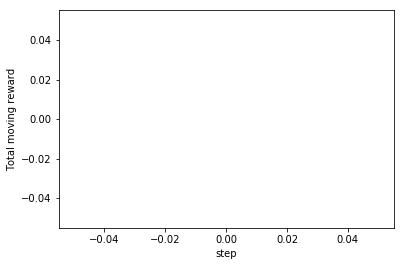

In [156]:
SESS = tf.Session()

with tf.device("/cpu:0"):
    OPT_A = tf.train.RMSPropOptimizer(LR_A, name='RMSPropA')
    OPT_C = tf.train.RMSPropOptimizer(LR_C, name='RMSPropC')
    GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)  # we only need its params
    workers = []
    # Create worker
    for i in range(N_WORKERS):
        i_name = 'W_%i' % i   # worker name
        workers.append(Worker(i_name, GLOBAL_AC))

COORD = tf.train.Coordinator()
SESS.run(tf.global_variables_initializer())

if OUTPUT_GRAPH:
    if os.path.exists(LOG_DIR):
        shutil.rmtree(LOG_DIR)
    tf.summary.FileWriter(LOG_DIR, SESS.graph)

worker_threads = []
for worker in workers:
    job = lambda: worker.work()
    t = threading.Thread(target=job)
    t.start()
    worker_threads.append(t)
COORD.join(worker_threads)

plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
plt.xlabel('step')
plt.ylabel('Total moving reward')
plt.show()

In [33]:
sess.close()
tf.reset_default_graph()